# <img style="float: left; padding-right: 10px; width: 45px" src="https://raw.githubusercontent.com/Harvard-IACS/2018-CS109A/master/content/styles/iacs.png"> CS109A Introduction to Data Science: 
## Homework 3 - Forecasting Bike Sharing Usage



**Harvard University**<br/>
**Fall 2018**<br/>
**Instructors**: Pavlos Protopapas, Kevin Rader

<hr style="height:2pt">

In [1]:
#RUN THIS CELL 
import requests
from IPython.core.display import HTML
styles = requests.get("https://raw.githubusercontent.com/Harvard-IACS/2018-CS109A/master/content/styles/cs109.css").text
HTML(styles)

### INSTRUCTIONS

- To submit your assignment follow the instructions given in canvas.
- Restart the kernel and run the whole notebook again before you submit. 
- If you submit individually and you have worked with someone, please include the name of your [one] partner below. 
- As much as possible, try and stick to the hints and functions we import at the top of the homework, as those are the ideas and tools the class supports and is aiming to teach. And if a problem specifies a particular library you're required to use that library, and possibly others from the import list.

Names of people you have worked with goes here: Avirel Epps, Erin Williams

<hr style="height:2pt">

![bike_sharing](fig/BSS.png)

<div class="theme">  Main Theme: Multiple Linear Regression, Subset Selection, Polynomial Regression </div>
### Overview 

You are hired by the administrators of the [Capital Bikeshare program](https://www.capitalbikeshare.com) program in Washington D.C., to **help them predict the hourly demand for rental bikes** and **give them suggestions on how to increase their revenue**. Your task is to prepare a short report summarizing your findings and make recommendations.

The predicted hourly demand could be used for planning the number of bikes that need to be available in the system at any given hour of the day. It costs the program money if bike stations are full and bikes cannot be returned, or empty and there are no bikes available. You will use multiple linear regression and polynomial regression and will explore techniques for subset selection to predict bike usage. The goal is to build a regression model that can predict the total number of bike rentals in a given hour of the day, based on all available information given to you. 

An example of a suggestion to increase revenue might be to offer discounts during certain times of the day either during holidays or non-holidays. Your suggestions will depend on your observations of the seasonality of ridership.

The data for this problem were collected from the Capital Bikeshare program over the course of two years (2011 and 2012).


### Use only the libraries below:

In [2]:
import numpy as np
import pandas as pd
import matplotlib
import matplotlib.pyplot as plt

import statsmodels.api as sm
from statsmodels.api import OLS

from sklearn import preprocessing
from sklearn.preprocessing import PolynomialFeatures
from sklearn.metrics import r2_score
from sklearn.model_selection import train_test_split

from pandas.plotting import scatter_matrix

from pandas.core import datetools

import seaborn as sns

import itertools
import warnings
warnings.filterwarnings("ignore")

%matplotlib inline

C:\Users\erina\Anaconda3\lib\site-packages\ipykernel_launcher.py:16: FutureWarning: The pandas.core.datetools module is deprecated and will be removed in a future version. Please use the pandas.tseries module instead.
  app.launch_new_instance()


## Data Exploration & Preprocessing, Multiple Linear Regression, Subset Selection


### Overview
The initial data set is provided in the file `data/BSS_hour_raw.csv`. You will first add features that will help with the analysis and then separate the data into training and test sets. Each row in this file represents the number of rides by registered users and casual users in a given hour of a specific date. There are 12 attributes in total describing besides the number of users the weather if it is a holiday or not etc: 


- `dteday` (date in the format YYYY-MM-DD, e.g. 2011-01-01)
- `season` (1 = winter, 2 = spring, 3 = summer, 4 = fall)
- `hour` (0 for 12 midnight, 1 for 1:00am, 23 for 11:00pm)
- `weekday` (0 through 6, with 0 denoting Sunday)
- `holiday` (1 = the day is a holiday, 0 = otherwise)
- `weather`
    - 1: Clear, Few clouds, Partly cloudy, Partly cloudy
    - 2: Mist + Cloudy, Mist + Broken clouds, Mist + Few clouds, Mist
    - 3: Light Snow, Light Rain + Thunderstorm
    - 4: Heavy Rain + Thunderstorm + Mist, Snow + Fog 
- `temp` (temperature in Celsius)
- `atemp` (apparent temperature, or relative outdoor temperature, in Celsius)
- `hum` (relative humidity)
- `windspeed` (wind speed)
- `casual` (number of rides that day made by casual riders, not registered in the system)
- `registered` (number of rides that day made by registered riders)

### General Hints
- Use pandas .describe() to see statistics for the dataset.
- When performing manipulations on column data it is useful and often more efficient to write a function and apply this function to the column as a whole without the need for iterating through the elements.
- A scatterplot matrix or correlation matrix are both good ways to see dependencies between multiple variables.
- For Question 2, a very useful pandas method is .groupby(). Make sure you aggregate the rest of the columns in a meaningful way. Print the dataframe to make sure all variables/columns are there!

### Resources 
http://pandas.pydata.org/pandas-docs/stable/generated/pandas.to_datetime.html

<div class="exercise"> <b> Question 1: Data Read-In and Cleaning </b> </div>

In this section, we read in the data and begin one of the most important analytic steps: verifying that the data is what it claims to be.

**1.1** Load the dataset from the csv file `data/BSS_hour_raw.csv` into a pandas dataframe that you name `bikes_df`. Do any of the variables' ranges or averages seem suspect? Do the data types make sense?

**1.2** Notice that the variable in column `dteday` is a pandas `object`, which is **not**  useful when you want to extract the elements of the date such as the year, month, and day. Convert `dteday` into a `datetime` object to prepare it for later analysis.

**1.3** Create three new columns in the dataframe:
- `year` with 0 for 2011, 1 for 2012, etc.
- `month` with 1 through 12, with 1 denoting January.
- `counts` with the total number of bike rentals for that **hour** (this is the response variable for later).

### Answers

#### **1.1** Load the dataset from the csv file `data/BSS_hour_raw.csv` into a pandas dataframe that you name `bikes_df`. Do any of the variables' ranges or averages seem suspect? Do the data types make sense?

In [3]:
bikes_df = pd.read_csv('data/BSS_hour_raw.csv', sep=",")
display(bikes_df.head())

,dteday,season,hour,holiday,weekday,workingday,weather,temp,atemp,hum,windspeed,casual,registered
0,2011-01-01,1,0,0,6,0,1,0.24,0.2879,0.81,0.0,3,13
1,2011-01-01,1,1,0,6,0,1,0.22,0.2727,0.80,0.0,8,32
2,2011-01-01,1,2,0,6,0,1,0.22,0.2727,0.80,0.0,5,27
3,2011-01-01,1,3,0,6,0,1,0.24,0.2879,0.75,0.0,3,10
4,2011-01-01,1,4,0,6,0,1,0.24,0.2879,0.75,0.0,0,1


In [4]:
bikes_df.describe()

,season,hour,holiday,weekday,workingday,weather,temp,atemp,hum,windspeed,casual,registered
count,17379.000000,17379.000000,17379.000000,17379.000000,17379.000000,17379.000000,17379.000000,17379.000000,17379.000000,17379.000000,17379.000000,17379.000000
mean,2.501640,11.546752,0.028770,3.003683,0.682721,1.425283,0.496987,0.475775,0.627229,0.190098,35.676218,153.786869
std,1.106918,6.914405,0.167165,2.005771,0.465431,0.639357,0.192556,0.171850,0.192930,0.122340,49.305030,151.357286
min,1.000000,0.000000,0.000000,0.000000,0.000000,1.000000,0.020000,0.000000,0.000000,0.000000,0.000000,0.000000
25%,2.000000,6.000000,0.000000,1.000000,0.000000,1.000000,0.340000,0.333300,0.480000,0.104500,4.000000,34.000000
50%,3.000000,12.000000,0.000000,3.000000,1.000000,1.000000,0.500000,0.484800,0.630000,0.194000,17.000000,115.000000
75%,3.000000,18.000000,0.000000,5.000000,1.000000,2.000000,0.660000,0.621200,0.780000,0.253700,48.000000,220.000000
max,4.000000,23.000000,1.000000,6.000000,1.000000,4.000000,1.000000,1.000000,1.000000,0.850700,367.000000,886.000000


In [5]:
# your code here
bikes_df.loc[bikes_df['registered'] == 886.00]

,dteday,season,hour,holiday,weekday,workingday,weather,temp,atemp,hum,windspeed,casual,registered
14773,2012-09-12,3,18,0,3,1,1,0.66,0.6212,0.44,0.2537,91,886


In [6]:
summer_df = bikes_df.loc[bikes_df['weather'] == 1]
display(summer_df.head())

,dteday,season,hour,holiday,weekday,workingday,weather,temp,atemp,hum,windspeed,casual,registered
0,2011-01-01,1,0,0,6,0,1,0.24,0.2879,0.81,0.0,3,13
1,2011-01-01,1,1,0,6,0,1,0.22,0.2727,0.80,0.0,8,32
2,2011-01-01,1,2,0,6,0,1,0.22,0.2727,0.80,0.0,5,27
3,2011-01-01,1,3,0,6,0,1,0.24,0.2879,0.75,0.0,3,10
4,2011-01-01,1,4,0,6,0,1,0.24,0.2879,0.75,0.0,0,1


**Answer**  
The majority of the data makes sense -- rides spike on holidays, there are more riders in the spring/summer/fall months than winter, and the highest volume of rides occur during the workday. However, the temperature seems to be skewed. Our summary shows an average temperature of $49^o$ C, which is $120^o$ F. In Washington, DC, average temperatures in July are $80^o$F/$20^o$C, and in January the averages are $38^o$F/$4^o$C. This tells us the data is skewed or some sort of scale is off. THe high temperature value is consistent across individual data points.

#### **1.2** Notice that the variable in column `dteday` is a pandas `object`, which is **not**  useful when you want to extract the elements of the date such as the year, month, and day. Convert `dteday` into a `datetime` object to prepare it for later analysis.

In [7]:
bikes_df['dteday']= pd.to_datetime(bikes_df['dteday'])
display(bikes_df.dteday.head())

0   2011-01-01
1   2011-01-01
2   2011-01-01
3   2011-01-01
4   2011-01-01
Name: dteday, dtype: datetime64[ns]

#### **1.3** Create three new columns in the dataframe:
- `year` with 0 for 2011, 1 for 2012, etc.
- `month` with 1 through 12, with 1 denoting January.
- `counts` with the total number of bike rentals for that hour (this is the response variable for later).

In [8]:
bikes_df['year']= pd.DatetimeIndex(bikes_df['dteday']).year
bikes_df['month']= pd.DatetimeIndex(bikes_df['dteday']).month
bikes_df['year']= bikes_df['year'].map({2012:1,2011:0})
bikes_df['counts']=bikes_df.casual+bikes_df.registered
display(bikes_df.head())

,dteday,season,hour,holiday,weekday,workingday,weather,temp,atemp,hum,windspeed,casual,registered,year,month,counts
0,2011-01-01,1,0,0,6,0,1,0.24,0.2879,0.81,0.0,3,13,0,1,16
1,2011-01-01,1,1,0,6,0,1,0.22,0.2727,0.80,0.0,8,32,0,1,40
2,2011-01-01,1,2,0,6,0,1,0.22,0.2727,0.80,0.0,5,27,0,1,32
3,2011-01-01,1,3,0,6,0,1,0.24,0.2879,0.75,0.0,3,10,0,1,13
4,2011-01-01,1,4,0,6,0,1,0.24,0.2879,0.75,0.0,0,1,0,1,1


<div class='exercise'> <b> Question 2: Exploratory Data Analysis. </b></div>

In this question, we continue validating the data, and begin hunting for patterns in ridership that shed light on who uses the service and why.

**2.1** Use pandas' `scatter_matrix` command to visualize the inter-dependencies among all predictors in the dataset.  Note and comment on any strongly related variables. [This will take several minutes to run. You may wish to comment it out until your final submission, or only plot a randomly-selected 10% of the rows]

**2.2** Make a plot showing the _average_ number of casual and registered riders during each hour of the day. `.groupby` and `.aggregate` should make this task easy. Comment on the trends you observe. 

**2.3** Use the variable `weather` to show how each weather category affects the relationships in question 2.2.  What do you observe?

**2.4** Make a new dataframe with the following subset of attributes from the previous dataset and with each entry being just **one** day: 

- `dteday`, the timestamp for that day (fine to set to noon or any other time) 
- `weekday`, the day of the week
- `weather`, the most severe weather that day
- `season`, the season that day falls in
- `temp`, the average temperature (normalized)
- `atemp`, the average atemp that day (normalized)
- `windspeed`, the average windspeed that day (normalized)
- `hum`, the average humidity that day (normalized)
- `casual`, the **total** number of rentals by casual users
- `registered`, the **total** number of rentals by registered users
- `counts`, the **total** number of rentals of that day

Name this dataframe `bikes_by_day`.

Make a plot showing  the _distribution_ of the number of casual and registered riders on each day of the week.

**2.5** Use `bikes_by_day` to visualize how the distribution of **total number of rides** per day (casual and registered riders combined) varies with the **season**. Do you see any **outliers**? Here we use the pyplot's boxplot function definition of an outlier as any value 1.5 times the IQR above the 75th percentile or 1.5 times the IQR below the 25th percentiles. If you see any outliers, identify those dates and investigate if they are a chance occurence, an error in the data collection, or a significant event (an online search of those date(s) might help). 



### Answers

#### **2.1** Use pandas' `scatter_matrix` command to visualize the inter-dependencies among all predictors in the dataset.  Note and comment on any strongly related variables. [This will take several minutes to run. You may wish to comment it out until your final submission, or only plot a randomly-selected 10% of the rows]

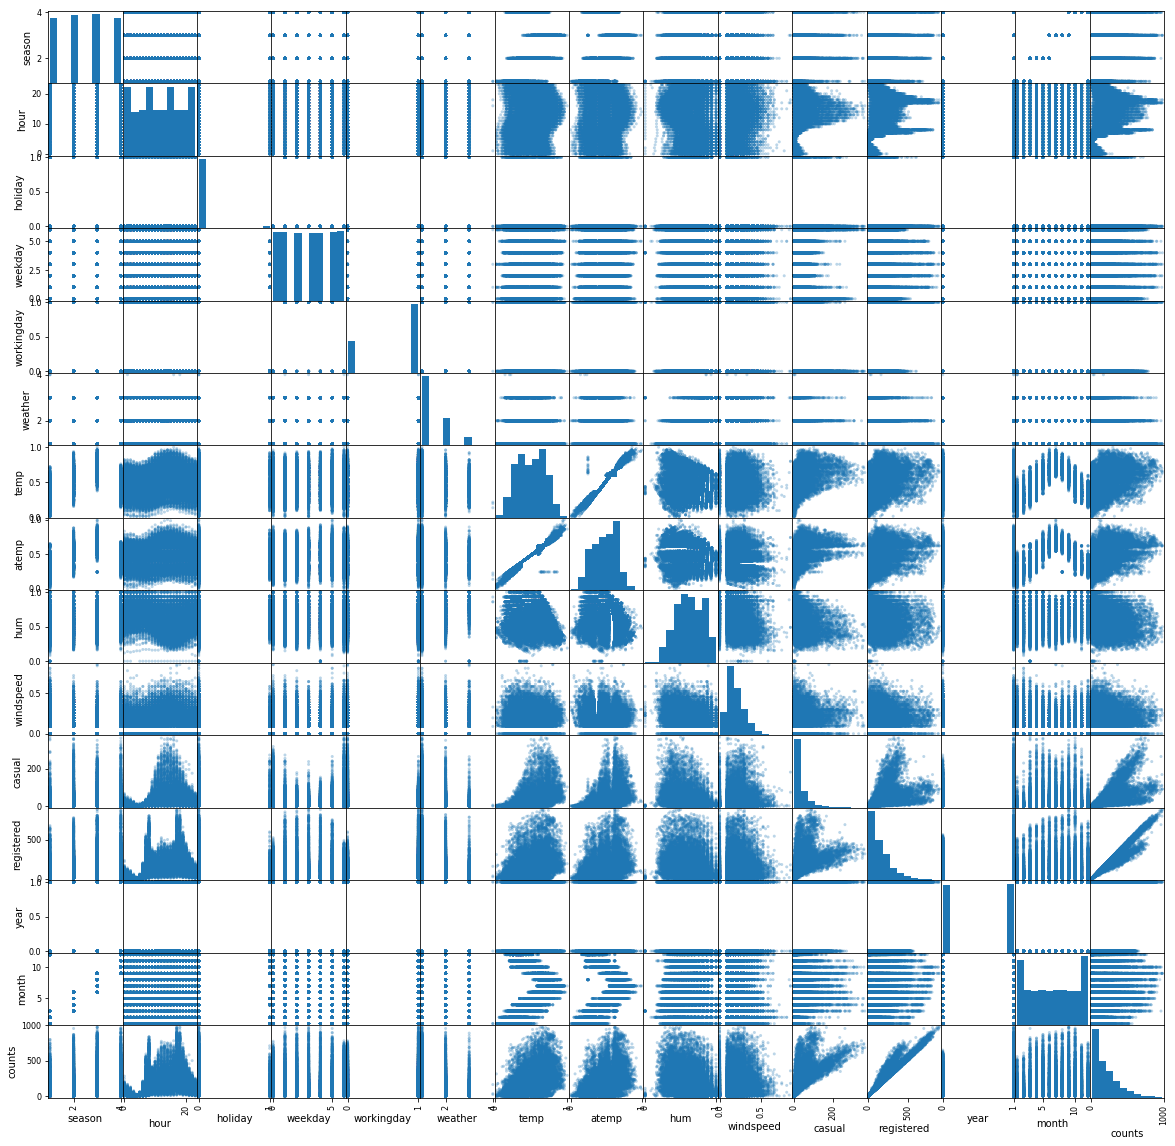

In [9]:
scatter_matrix(bikes_df, alpha = 0.3, figsize=(20,20));

**Answer**  
We don't see any surprising relationships. Most notably, counts increases during daytime hours and is higher during late spring, summer, and early fall months. Additionally, counts is closely realted to the weather type, with significantly higher values when the weather is rated as "1" or "2".

#### **2.2** Make a plot showing the _average_ number of casual and registered riders during each hour of the day. `.groupby` and `.aggregate` should make this task easy. Comment on the trends you observe. 

In [10]:
hour_casual_mean = bikes_df.groupby('hour').agg({'casual':'mean'})
hour_registered_mean= bikes_df.groupby('hour').agg({'registered':'mean'})

In [11]:
avg_hour_frames = [hour_casual_mean,hour_registered_mean]
avg_hour_df = pd.concat(avg_hour_frames, axis = 1)

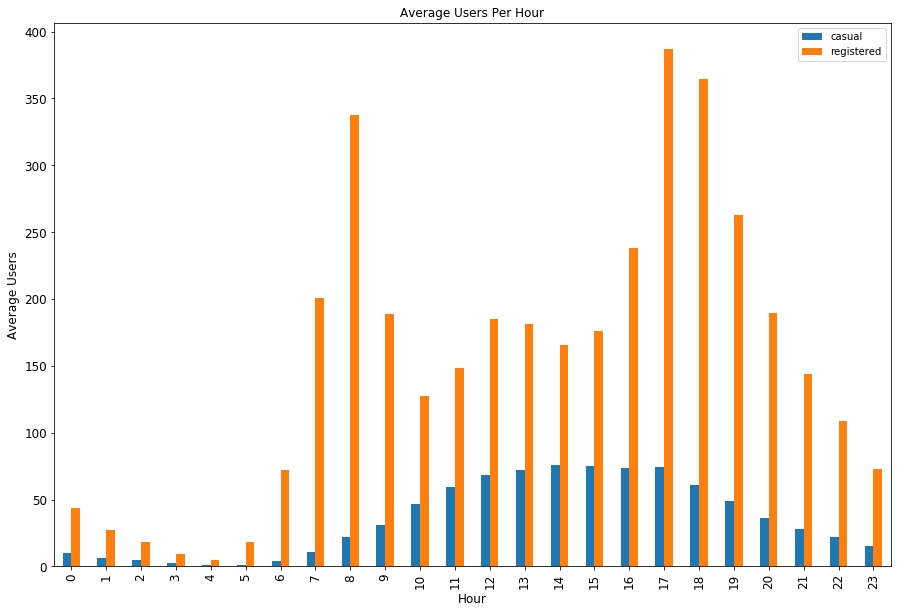

In [12]:
user_plot = avg_hour_df.plot(kind='bar', title ="Average Users Per Hour", figsize=(15, 10), legend=True, fontsize=12)
user_plot.set_xlabel("Hour", fontsize=12)
user_plot.set_ylabel("Average Users", fontsize=12)
plt.show()

**Answer**  
We can easily observe that rides for registered users spike from 0700-0900 and again from 1600-1900, which generally aligns with rush hour. This makes sense, since registered users likely rely on the bike share as a means of commuting. Casual users spike from 1200 to 1800, indicating that they are likely tourists who are using the bike share to see DC or get to an attraction.


#### **2.3** Use the variable `weather` to show how each weather category affects the relationships in question 2.2.  What do you observe?

In [13]:
# sort into data frames for each weather type
weather1_df = bikes_df.loc[bikes_df['weather'] == 1]
weather2_df = bikes_df.loc[bikes_df['weather'] == 2]
weather3_df = bikes_df.loc[bikes_df['weather'] == 3]
weather4_df = bikes_df.loc[bikes_df['weather'] == 4]

In [14]:
mean_weather1 = weather1_df.groupby(['hour']).agg({'casual':'mean', 'registered':'mean'})
mean_weather2 = weather2_df.groupby(['hour']).agg({'casual':'mean', 'registered':'mean'})
mean_weather3 = weather3_df.groupby(['hour']).agg({'casual':'mean', 'registered':'mean'})
mean_weather4 = weather4_df.groupby(['hour']).agg({'casual':'mean', 'registered':'mean'})

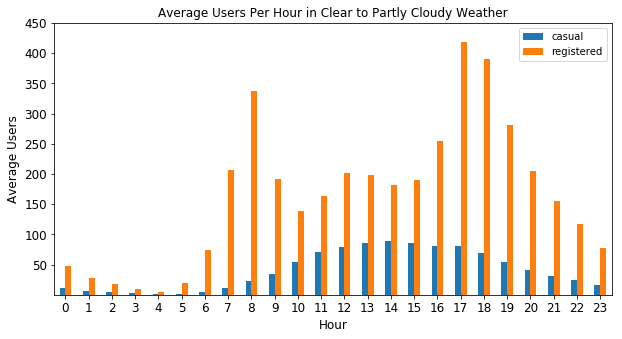

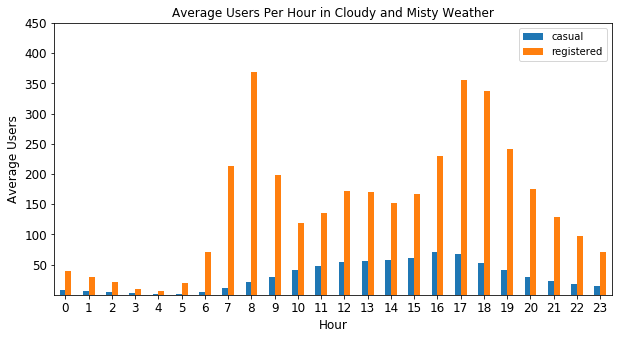

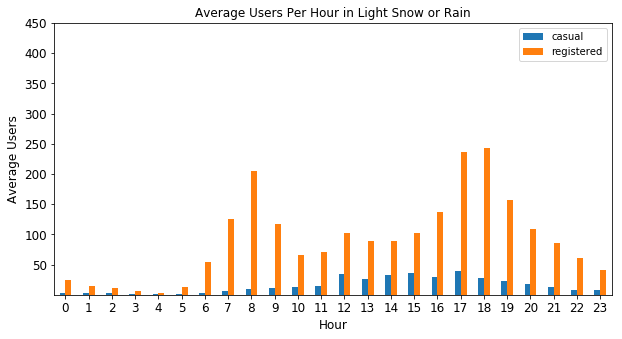

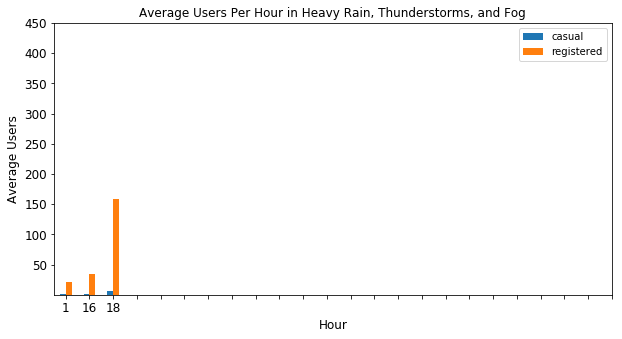

In [15]:
user_plot1 = mean_weather1.plot.bar(rot = 0, title ="Average Users Per Hour in Clear to Partly Cloudy Weather", figsize=(10, 5), legend=True, fontsize=12)
user_plot1.set_xlabel("Hour", fontsize=12)
user_plot1.set_ylabel("Average Users", fontsize=12)
user_plot1.set_yticks([50,100,150,200,250,300,350,400,450])
plt.show()

user_plot2 = mean_weather2.plot.bar(rot = 0, title ="Average Users Per Hour in Cloudy and Misty Weather", figsize=(10, 5), legend=True, fontsize=12)
user_plot2.set_xlabel("Hour", fontsize=12)
user_plot2.set_ylabel("Average Users", fontsize=12)
user_plot2.set_yticks([50,100,150,200,250,300,350,400,450])
plt.show()

user_plot3 = mean_weather3.plot.bar(rot = 0, title ="Average Users Per Hour in Light Snow or Rain", figsize=(10, 5), legend=True, fontsize=12)
user_plot3.set_xlabel("Hour", fontsize=12)
user_plot3.set_ylabel("Average Users", fontsize=12)
user_plot3.set_yticks([50,100,150,200,250,300,350,400,450])
plt.show()

user_plot4 = mean_weather4.plot.bar(rot = 0, title ="Average Users Per Hour in Heavy Rain, Thunderstorms, and Fog", figsize=(10, 5), legend=True, fontsize=12)
user_plot4.set_xlabel("Hour", fontsize=12)
user_plot4.set_ylabel("Average Users", fontsize=12)
user_plot4.set_yticks([50,100,150,200,250,300,350,400,450])
user_plot4.set_xticks([0,1,2,3,4,5,6,7,8,9,10,11,12,13,14,15,16,17,18,19,20,21,22,23])
plt.show()

**Answer**
We can see that while the trend line generally holds, the averages begin to fall as weather gets bad (decreasing from 1 to 2, and from 2 to 3), and riders almost completely drop off during the worst weather conditions. 

#### **2.4** Make a new dataframe with the following subset of attributes from the previous dataset and with each entry being just **one** day: 

- `dteday`, the timestamp for that day (fine to set to noon or any other time) 
- `weekday`, the day of the week
- `weather`, the most severe weather that day
- `season`, the season that day falls in
- `temp`, the average temperature (normalized)
- `atemp`, the average atemp that day (normalized)
- `windspeed`, the average windspeed that day (normalized)
- `hum`, the average humidity that day (normalized)
- `casual`, the **total** number of rentals by casual users
- `registered`, the **total** number of rentals by registered users
- `counts`, the **total** number of rentals of that day

#### Name this dataframe `bikes_by_day`.

#### Make a plot showing  the _distribution_ of the number of casual and registered riders on each day of the week.

In [16]:
bikes_by_day = pd.DataFrame(bikes_df.groupby('dteday').agg({
    'dteday': np.min,
    'temp': np.mean,
    'atemp': np.mean,
    'windspeed': np.mean,
    'hum': np.mean,
    'casual': np.sum,
    'registered': np.sum,
    'counts': np.sum
}))
bikes_by_day2 = pd.DataFrame()
bikes_by_day2['dteday'] = pd.to_datetime(bikes_df['dteday'])
bikes_by_day2['weekday'] = pd.DatetimeIndex(bikes_df['dteday']).weekday #0 = monday, 6 = Sunday
bikes_by_day2['season'] = pd.DatetimeIndex(bikes_df['dteday']).month
bikes_by_day2['season'] = ((bikes_by_day2.season%12 + 3)//3)-1 # 0 = winter, 1 = spring, 2 = summer, 3 = fall
bikes_by_day2 = bikes_by_day2.drop_duplicates(["dteday"])
bikes_by_day2.set_index('dteday')
bikes_by_day = pd.merge(bikes_by_day, bikes_by_day2, on=['dteday'])
display(bikes_by_day.head())

,dteday,temp,atemp,windspeed,hum,casual,registered,counts,weekday,season
0,2011-01-01,0.344167,0.363625,0.160446,0.805833,331,654,985,5,0
1,2011-01-02,0.363478,0.353739,0.248539,0.696087,131,670,801,6,0
2,2011-01-03,0.196364,0.189405,0.248309,0.437273,120,1229,1349,0,0
3,2011-01-04,0.200000,0.212122,0.160296,0.590435,108,1454,1562,1,0
4,2011-01-05,0.226957,0.229270,0.186900,0.436957,82,1518,1600,2,0


In [17]:
casual_mean = bikes_by_day.groupby('weekday').agg({'casual':'mean'})
registered_mean= bikes_by_day.groupby('weekday').agg({'registered':'mean'})

In [18]:
avg_week_frames = [casual_mean,registered_mean]
avg_week_df = pd.concat(avg_week_frames, axis = 1)

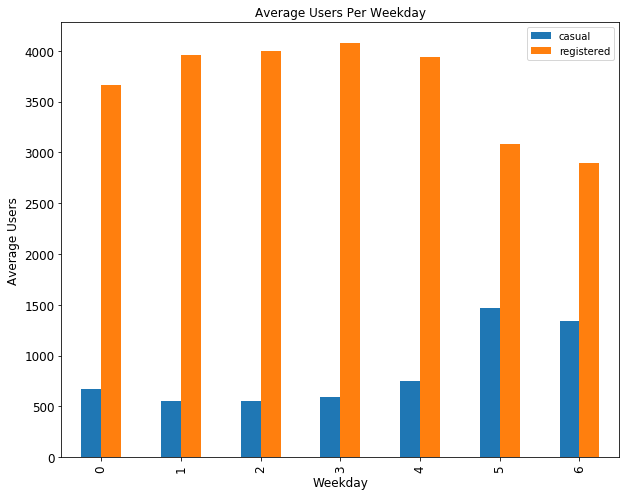

In [19]:
user_plot = avg_week_df.plot(kind='bar', title ="Average Users Per Weekday", figsize=(10, 8), legend=True, fontsize=12)
user_plot.set_xlabel("Weekday", fontsize=12)
user_plot.set_ylabel("Average Users", fontsize=12)
plt.show()

**Answer**  
Registered users are highest during weekdays. Registered users likely use the bikes to commute to work and run errands, so this makes sense. Casual users increase on weekends. Generally speaking, more tourists visit DC on the weekends, so this also makes sense.


**2.5** Use `bikes_by_day` to visualize how the distribution of **total number of rides** per day (casual and registered riders combined) varies with the **season**. Do you see any **outliers**? Here we use the pyplot's boxplot function definition of an outlier as any value 1.5 times the IQR above the 75th percentile or 1.5 times the IQR below the 25th percentiles. If you see any outliers, identify those dates and investigate if they are a chance occurence, an error in the data collection, or a significant event (an online search of those date(s) might help). 

In [20]:
# your code here 
display(bikes_by_day.head())

,dteday,temp,atemp,windspeed,hum,casual,registered,counts,weekday,season
0,2011-01-01,0.344167,0.363625,0.160446,0.805833,331,654,985,5,0
1,2011-01-02,0.363478,0.353739,0.248539,0.696087,131,670,801,6,0
2,2011-01-03,0.196364,0.189405,0.248309,0.437273,120,1229,1349,0,0
3,2011-01-04,0.200000,0.212122,0.160296,0.590435,108,1454,1562,1,0
4,2011-01-05,0.226957,0.229270,0.186900,0.436957,82,1518,1600,2,0


In [21]:
bikes_by_day_winter = bikes_by_day.loc[bikes_by_day['season'] == 0]
bikes_by_day_spring = bikes_by_day.loc[bikes_by_day['season'] == 1]
bikes_by_day_summer = bikes_by_day.loc[bikes_by_day['season'] == 2]
bikes_by_day_fall = bikes_by_day.loc[bikes_by_day['season'] == 3]

In [22]:
display(bikes_by_day_winter.head())

,dteday,temp,atemp,windspeed,hum,casual,registered,counts,weekday,season
0,2011-01-01,0.344167,0.363625,0.160446,0.805833,331,654,985,5,0
1,2011-01-02,0.363478,0.353739,0.248539,0.696087,131,670,801,6,0
2,2011-01-03,0.196364,0.189405,0.248309,0.437273,120,1229,1349,0,0
3,2011-01-04,0.200000,0.212122,0.160296,0.590435,108,1454,1562,1,0
4,2011-01-05,0.226957,0.229270,0.186900,0.436957,82,1518,1600,2,0


In [23]:
test = bikes_by_day_winter.loc[bikes_by_day_winter['weekday']== 1]
display(test.head())

,dteday,temp,atemp,windspeed,hum,casual,registered,counts,weekday,season
3,2011-01-04,0.200000,0.212122,0.160296,0.590435,108,1454,1562,1,0
10,2011-01-11,0.169091,0.191464,0.122132,0.686364,43,1220,1263,1,0
17,2011-01-18,0.216667,0.232333,0.146775,0.861667,9,674,683,1,0
24,2011-01-25,0.223478,0.234526,0.129796,0.616957,186,1799,1985,1,0
31,2011-02-01,0.192174,0.234530,0.053213,0.829565,47,1313,1360,1,0


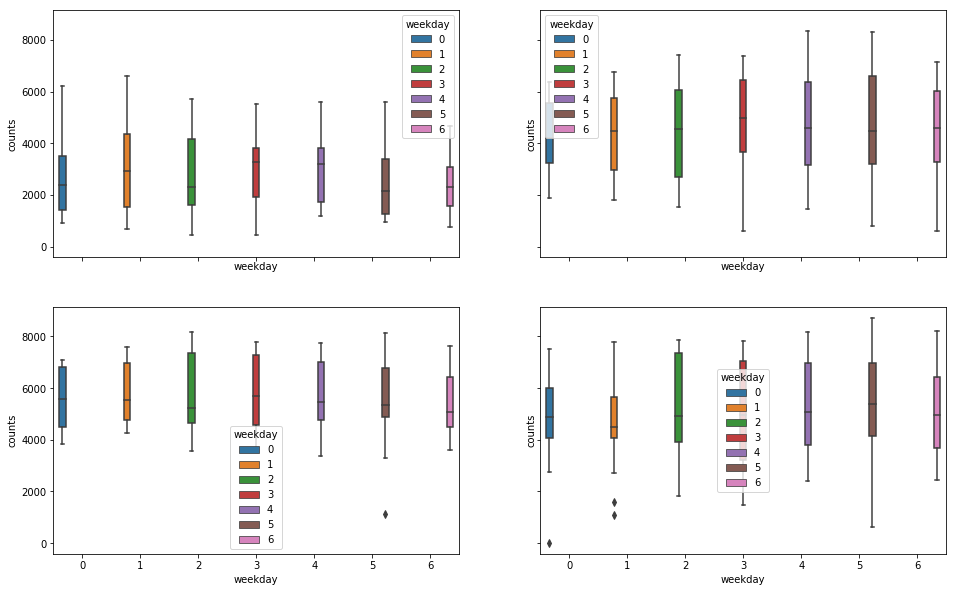

In [24]:
fig, axes = plt.subplots(nrows=2, ncols=2,sharex=True, sharey=True, figsize=(16, 10));
sns.boxplot(x='weekday', hue="weekday", y='counts', data=bikes_by_day_winter,  ax=axes[0,0]);
sns.boxplot(x='weekday', hue="weekday", y='counts', data=bikes_by_day_spring, ax=axes[0,1]);
sns.boxplot(x='weekday', hue="weekday", y='counts', data=bikes_by_day_summer, ax=axes[1,0]);
sns.boxplot(x='weekday', hue="weekday", y='counts', data=bikes_by_day_fall, ax=axes[1,1]);

**Check the outliers that are visible on these plots**

In [25]:
def find_quartiles(data):
    q1 = np.percentile(data, 25)
    q3 = np.percentile(data, 75)
    return q1, q3

def find_outlier(data, q1, q3):
    outliers = []
    lower = q1 - 1.5 * (q3 - q1)
    upper = q3 + 1.5 * (q3 - q1)
    for i in data:
        if i <= lower or i >= upper:
            outliers.append(i)
        else:
            pass
    return outliers

In [26]:
summer_outliers = bikes_by_day_summer.loc[bikes_by_day_summer['weekday']==5]
summer_outliers2= summer_outliers['counts']
summer_quartiles = find_quartiles(summer_outliers2)
find_summer_outliers = find_outlier(summer_outliers2,summer_quartiles[0],summer_quartiles[1])
find_summer_outliers

[1115]

In [27]:
display(summer_outliers.loc[summer_outliers['counts']==1115])

,dteday,temp,atemp,windspeed,hum,casual,registered,counts,weekday,season
238,2011-08-27,0.68,0.635556,0.375617,0.85,226,889,1115,5,2


In [28]:
fall_outliers_su = bikes_by_day_fall.loc[bikes_by_day_fall['weekday']==0]
fall_quartiles_su = find_quartiles(fall_outliers_su['counts'])
find_fall_su_outliers = find_outlier(fall_outliers_su['counts'],fall_quartiles_su[0],fall_quartiles_su[1])
find_fall_su_outliers

[22]

In [29]:
display(fall_outliers_su.loc[fall_outliers_su['counts']==22])

,dteday,temp,atemp,windspeed,hum,casual,registered,counts,weekday,season
667,2012-10-29,0.44,0.4394,0.3582,0.88,2,20,22,0,3


In [30]:
fall_outliers_m = bikes_by_day_fall.loc[bikes_by_day_fall['weekday']==1]
fall_quartiles_m = find_quartiles(fall_outliers_m['counts'])
find_fall_m_outliers = find_outlier(fall_outliers_m['counts'],fall_quartiles_m[0],fall_quartiles_m[1])
find_fall_m_outliers

[1607, 1096]

In [31]:
display(fall_outliers_m.loc[fall_outliers_m['counts']==1607])
display(fall_outliers_m.loc[fall_outliers_m['counts']==1096])

,dteday,temp,atemp,windspeed,hum,casual,registered,counts,weekday,season
325,2011-11-22,0.416667,0.421696,0.118792,0.9625,69,1538,1607,1,3


,dteday,temp,atemp,windspeed,hum,casual,registered,counts,weekday,season
668,2012-10-30,0.318182,0.309909,0.213009,0.825455,87,1009,1096,1,3


In [32]:
bikes_df.loc[bikes_df['dteday']=='2011-08-27']

,dteday,season,hour,holiday,weekday,workingday,weather,temp,atemp,hum,windspeed,casual,registered,year,month,counts
5618,2011-08-27,3,0,0,6,0,1,0.70,0.6667,0.84,0.1045,33,112,0,8,145
5619,2011-08-27,3,1,0,6,0,1,0.70,0.6667,0.84,0.1642,13,51,0,8,64
5620,2011-08-27,3,2,0,6,0,1,0.70,0.6667,0.84,0.1940,18,59,0,8,77
5621,2011-08-27,3,3,0,6,0,2,0.70,0.6667,0.84,0.2239,8,22,0,8,30
5622,2011-08-27,3,4,0,6,0,2,0.70,0.6667,0.84,0.2239,1,3,0,8,4
5623,2011-08-27,3,5,0,6,0,2,0.70,0.6667,0.84,0.2985,1,11,0,8,12
5624,2011-08-27,3,6,0,6,0,2,0.70,0.6667,0.84,0.2985,3,15,0,8,18
5625,2011-08-27,3,7,0,6,0,2,0.70,0.6667,0.84,0.3582,2,26,0,8,28
5626,2011-08-27,3,8,0,6,0,2,0.70,0.6667,0.84,0.2537,14,62,0,8,76
5627,2011-08-27,3,9,0,6,0,2,0.70,0.6667,0.84,0.4179,28,128,0,8,156


**Answer**  
We see outliers on the following days:  
Friday, 2011-08-27: Weather value was a "3" from 1100 onward.  
Monday, 2011-11-22: Weather value was a "3" for the entire day.  
Sunday, 2012-10-29 and Monday, 2012-10-30: Weather value was a "3" for both days.  
These weather values may have caused extremely low useage on these days.  

<div class='exercise'> <b> Question 3: Prepare the data for Regression </b> </div>

In order to build and evaluate our regression models, a little data cleaning is needed.  In this problem, we will explicitly create binary variables to represent the categorical predictors, set up the train-test split in a careful way, remove ancillary variables, and do a little data exploration that will be useful to consider in the regression models later.

**3.1** Using `bikes_df`, with hourly data about rentals, convert the categorical attributes ('season', 'month', 'weekday', 'weather') into multiple binary attributes using **one-hot encoding**.

**3.2** Split the updated `bikes_df` dataset in a train and test part. Do this in a 'stratified' fashion, ensuring that all months are equally represented in each set. Explain your choice for a splitting algorithm. 

**3.3** Although we asked you to create your train and test set, but for consistency and easy checking, we ask that for the rest of this problem set you use the train and test set provided in the he files `data/BSS_train.csv` and `data/BSS_test.csv`. Read these two files into dataframes `BSS_train` and `BSS_test`, respectively. Remove the `dteday` column from both the train and the test dataset (its format cannot be used for analysis). Also, remove any predictors that would make predicting the `count` trivial. Note we gave more meaningful names to the one-hot encoded variables.



#### Answers

#### **3.1** Using `bikes_df`, with hourly data about rentals, convert the categorical attributes ('season', 'month', 'weekday', 'weather') into multiple binary attributes using **one-hot encoding**.

In [33]:
bikes_df_orig = bikes_df.copy()

In [34]:
#Months weekdays and weather (better way to do it)
bikes_df = pd.get_dummies(bikes_df_orig, columns=['season','month', 'weekday', 'weather'], drop_first=True)
bikes_df['month']= pd.DatetimeIndex(bikes_df['dteday']).month


In [35]:
display(bikes_df.head())
display(bikes_df.info())

,dteday,hour,holiday,workingday,temp,atemp,hum,windspeed,casual,registered,...,weekday_1,weekday_2,weekday_3,weekday_4,weekday_5,weekday_6,weather_2,weather_3,weather_4,month
0,2011-01-01,0,0,0,0.24,0.2879,0.81,0.0,3,13,...,0,0,0,0,0,1,0,0,0,1
1,2011-01-01,1,0,0,0.22,0.2727,0.80,0.0,8,32,...,0,0,0,0,0,1,0,0,0,1
2,2011-01-01,2,0,0,0.22,0.2727,0.80,0.0,5,27,...,0,0,0,0,0,1,0,0,0,1
3,2011-01-01,3,0,0,0.24,0.2879,0.75,0.0,3,10,...,0,0,0,0,0,1,0,0,0,1
4,2011-01-01,4,0,0,0.24,0.2879,0.75,0.0,0,1,...,0,0,0,0,0,1,0,0,0,1


<class 'pandas.core.frame.DataFrame'>
RangeIndex: 17379 entries, 0 to 17378
Data columns (total 36 columns):
dteday        17379 non-null datetime64[ns]
hour          17379 non-null int64
holiday       17379 non-null int64
workingday    17379 non-null int64
temp          17379 non-null float64
atemp         17379 non-null float64
hum           17379 non-null float64
windspeed     17379 non-null float64
casual        17379 non-null int64
registered    17379 non-null int64
year          17379 non-null int64
counts        17379 non-null int64
season_2      17379 non-null uint8
season_3      17379 non-null uint8
season_4      17379 non-null uint8
month_2       17379 non-null uint8
month_3       17379 non-null uint8
month_4       17379 non-null uint8
month_5       17379 non-null uint8
month_6       17379 non-null uint8
month_7       17379 non-null uint8
month_8       17379 non-null uint8
month_9       17379 non-null uint8
month_10      17379 non-null uint8
month_11      17379 non-null uint8

None

####  **3.2** Split the updated `bikes_df` dataset in a train and test part. Do this in a 'stratified' fashion, ensuring that all months are equally represented in each set. Explain your choice for a splitting algorithm.

In [36]:
try:
    # Doesn't work: a value is missing
    train_data, test_data = train_test_split(bikes_df, test_size = 0.1, 
                                             stratify=bikes_df['month'])
except:
    # Count the missing lines and drop them
    missing_rows = np.isnan(bikes_df['month'])
    print("Uh oh, {} lines missing data! Dropping them".format(np.sum(missing_rows)))
    bikes_df = bikes_df.dropna(subset=['month'])
    train_data, test_data = train_test_split(bikes_df, test_size = 0.1, 
                                             stratify=bikes_df['month'])

In [37]:
train_data.shape, test_data.shape

((15641, 36), (1738, 36))

**Answer**  
When we split the data, we are stratifying by month. This ensure we have an accurate representation of data for each month (generally, 1/12th of the data). If we don't stratify, we risk getting excessive amounts of data from a particular month, or having a particular month underrepresented in our data. This also impacts the data we get for a particular season. We've also chosen to drop data points where the month isn't entered. While these missing values could possibly be filled as we look at our data more closely, it would be time consuming and we don't lose a significant amount of data by dropping.


#### **3.3** Although we asked you to create your train and test set, but for consistency and easy checking, we ask that for the rest of this problem set you use the train and test set provided in the he files `data/BSS_train.csv` and `data/BSS_test.csv`. Read these two files into dataframes `BSS_train` and `BSS_test`, respectively. Remove the `dteday` column from both the train and the test dataset (its format cannot be used for analysis). Also, remove any predictors that would make predicting the `count` trivial. Note we gave more meaningful names to the one-hot encoded variables.

In [38]:
BSS_train = pd.read_csv('data/BSS_train.csv', sep=",")
display(BSS_train.head())

BSS_test = pd.read_csv('data/BSS_test.csv', sep=",")
display(BSS_test.head())

,Unnamed: 0,dteday,hour,holiday,year,workingday,temp,atemp,hum,windspeed,...,Dec,Mon,Tue,Wed,Thu,Fri,Sat,Cloudy,Snow,Storm
0,0,2011-01-01,0,0,0,0,0.24,0.2879,0.81,0.0,...,0,0,0,0,0,0,1,0,0,0
1,1,2011-01-01,1,0,0,0,0.22,0.2727,0.80,0.0,...,0,0,0,0,0,0,1,0,0,0
2,2,2011-01-01,2,0,0,0,0.22,0.2727,0.80,0.0,...,0,0,0,0,0,0,1,0,0,0
3,3,2011-01-01,3,0,0,0,0.24,0.2879,0.75,0.0,...,0,0,0,0,0,0,1,0,0,0
4,4,2011-01-01,4,0,0,0,0.24,0.2879,0.75,0.0,...,0,0,0,0,0,0,1,0,0,0


,Unnamed: 0,dteday,hour,holiday,year,workingday,temp,atemp,hum,windspeed,...,Dec,Mon,Tue,Wed,Thu,Fri,Sat,Cloudy,Snow,Storm
0,6,2011-01-01,6,0,0,0,0.22,0.2727,0.80,0.0000,...,0,0,0,0,0,0,1,0,0,0
1,9,2011-01-01,9,0,0,0,0.32,0.3485,0.76,0.0000,...,0,0,0,0,0,0,1,0,0,0
2,20,2011-01-01,20,0,0,0,0.40,0.4091,0.87,0.2537,...,0,0,0,0,0,0,1,1,0,0
3,33,2011-01-02,10,0,0,0,0.36,0.3485,0.81,0.2239,...,0,0,0,0,0,0,0,1,0,0
4,35,2011-01-02,12,0,0,0,0.36,0.3333,0.66,0.2985,...,0,0,0,0,0,0,0,1,0,0


In [39]:
BSS_train = BSS_train.drop(['dteday', 'casual', 'registered'], axis=1) #drop irrelevant predictors
BSS_test = BSS_test.drop(['dteday', 'casual', 'registered'], axis=1) #drop irrelevant predictors

In [40]:
display(BSS_train.head(), BSS_test.head(), BSS_test.info())

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 3476 entries, 0 to 3475
Data columns (total 33 columns):
Unnamed: 0    3476 non-null int64
hour          3476 non-null int64
holiday       3476 non-null int64
year          3476 non-null int64
workingday    3476 non-null int64
temp          3476 non-null float64
atemp         3476 non-null float64
hum           3476 non-null float64
windspeed     3476 non-null float64
counts        3476 non-null int64
spring        3476 non-null int64
summer        3476 non-null int64
fall          3476 non-null int64
Feb           3476 non-null int64
Mar           3476 non-null int64
Apr           3476 non-null int64
May           3476 non-null int64
Jun           3476 non-null int64
Jul           3476 non-null int64
Aug           3476 non-null int64
Sept          3476 non-null int64
Oct           3476 non-null int64
Nov           3476 non-null int64
Dec           3476 non-null int64
Mon           3476 non-null int64
Tue           3476 non-null int64
W

,Unnamed: 0,hour,holiday,year,workingday,temp,atemp,hum,windspeed,counts,...,Dec,Mon,Tue,Wed,Thu,Fri,Sat,Cloudy,Snow,Storm
0,0,0,0,0,0,0.24,0.2879,0.81,0.0,16,...,0,0,0,0,0,0,1,0,0,0
1,1,1,0,0,0,0.22,0.2727,0.80,0.0,40,...,0,0,0,0,0,0,1,0,0,0
2,2,2,0,0,0,0.22,0.2727,0.80,0.0,32,...,0,0,0,0,0,0,1,0,0,0
3,3,3,0,0,0,0.24,0.2879,0.75,0.0,13,...,0,0,0,0,0,0,1,0,0,0
4,4,4,0,0,0,0.24,0.2879,0.75,0.0,1,...,0,0,0,0,0,0,1,0,0,0


,Unnamed: 0,hour,holiday,year,workingday,temp,atemp,hum,windspeed,counts,...,Dec,Mon,Tue,Wed,Thu,Fri,Sat,Cloudy,Snow,Storm
0,6,6,0,0,0,0.22,0.2727,0.80,0.0000,2,...,0,0,0,0,0,0,1,0,0,0
1,9,9,0,0,0,0.32,0.3485,0.76,0.0000,14,...,0,0,0,0,0,0,1,0,0,0
2,20,20,0,0,0,0.40,0.4091,0.87,0.2537,36,...,0,0,0,0,0,0,1,1,0,0
3,33,10,0,0,0,0.36,0.3485,0.81,0.2239,53,...,0,0,0,0,0,0,0,1,0,0
4,35,12,0,0,0,0.36,0.3333,0.66,0.2985,93,...,0,0,0,0,0,0,0,1,0,0


None

<div class='exercise'> <b> Question 4: Multiple Linear Regression </b> </div>

**4.1** Use statsmodels to fit a multiple linear regression model to the training set using all the predictors (no interactions or polynomial terms) to predict `counts`, and report its $R^2$ score on the train and test sets.

**4.2** Examine the estimated coefficients and report which ones are statistically significant at a significance level of 5% (p-value < 0.05). You should see some strange values, such as `July` producing 93 fewer rentals, all else equal, than January.

**4.3** To diagnose the model, make two plots: first a histogram of the residuals, and second a plot of the residuals of the fitted model ${e} = y - \hat{y}$ as a function of the predicted value $\hat{y}$. Draw a horizontal line denoting the zero residual value on the Y-axis. What do the plots reveal about the OLS assumptions (linearity, constant variance, and normality)?

**4.4** Perhaps we can do better via a model with polynomial terms. Build a dataset `X_train_poly` from `X_train` with added $x^2$ terms for `temp`, `hour`, and `humidity`. Are these polynomial terms important? How does predicted ridership change as each of `temp`, `hour`, and `humidity` increase?

**4.5** The strange coefficients from 4.2 could also come from _multicolinearity_, where one or more predictors capture the same information as existing predictors. Why can multicolinearity lead to erroneous coefficient values? Create a temporary dataset `X_train_drop` that drops the following 'redundant' predictors from `X_train`:  `workingday` `atemp` `spring` `summer` and `fall`. Fit a multiple linear regression model to `X_train_drop`. Are the estimates more sensible in this model?


### Answers
#### **4.1** Use statsmodels to fit a multiple linear regression model to the training set using all the predictors (no interactions or polynomial terms) to predict `counts`, and report its $R^2$ score on the train and test sets.

In [41]:
y_train = BSS_train['counts']
y_test = BSS_test['counts']

def build_model_design(df):
    design_mat = df[['hour','holiday','year','workingday','temp', 'atemp', 'hum', 'windspeed', 'spring', 'summer', 'fall', 'Feb', 'Mar', 'Apr', 'May', 'Jun', 'Jul', 'Aug', 'Sept', 'Oct', 'Nov', 'Dec', 'Mon', 'Tue', 'Wed', 'Thu', 'Fri', 'Sat', 'Cloudy', 'Snow', 'Storm']].copy()
    #Add a constant
    design_mat = sm.add_constant(design_mat)
    return design_mat

X_train = build_model_design(BSS_train)
X_test = build_model_design(BSS_test)
display(X_train.head(), X_test.head(), y_train.head(), y_test.head())

,const,hour,holiday,year,workingday,temp,atemp,hum,windspeed,spring,...,Dec,Mon,Tue,Wed,Thu,Fri,Sat,Cloudy,Snow,Storm
0,1.0,0,0,0,0,0.24,0.2879,0.81,0.0,0,...,0,0,0,0,0,0,1,0,0,0
1,1.0,1,0,0,0,0.22,0.2727,0.80,0.0,0,...,0,0,0,0,0,0,1,0,0,0
2,1.0,2,0,0,0,0.22,0.2727,0.80,0.0,0,...,0,0,0,0,0,0,1,0,0,0
3,1.0,3,0,0,0,0.24,0.2879,0.75,0.0,0,...,0,0,0,0,0,0,1,0,0,0
4,1.0,4,0,0,0,0.24,0.2879,0.75,0.0,0,...,0,0,0,0,0,0,1,0,0,0


,const,hour,holiday,year,workingday,temp,atemp,hum,windspeed,spring,...,Dec,Mon,Tue,Wed,Thu,Fri,Sat,Cloudy,Snow,Storm
0,1.0,6,0,0,0,0.22,0.2727,0.80,0.0000,0,...,0,0,0,0,0,0,1,0,0,0
1,1.0,9,0,0,0,0.32,0.3485,0.76,0.0000,0,...,0,0,0,0,0,0,1,0,0,0
2,1.0,20,0,0,0,0.40,0.4091,0.87,0.2537,0,...,0,0,0,0,0,0,1,1,0,0
3,1.0,10,0,0,0,0.36,0.3485,0.81,0.2239,0,...,0,0,0,0,0,0,0,1,0,0
4,1.0,12,0,0,0,0.36,0.3333,0.66,0.2985,0,...,0,0,0,0,0,0,0,1,0,0


0    16
1    40
2    32
3    13
4     1
Name: counts, dtype: int64

0     2
1    14
2    36
3    53
4    93
Name: counts, dtype: int64

In [42]:
model1 = sm.OLS(
    BSS_train.counts,
    sm.add_constant(BSS_train[['hour','holiday','year','workingday','temp', 'atemp', 'hum', 'windspeed', 'spring', 'summer', 'fall', 'Feb', 'Mar', 'Apr', 'May', 'Jun', 'Jul', 'Aug', 'Sept', 'Oct', 'Nov', 'Dec', 'Mon', 'Tue', 'Wed', 'Thu', 'Fri', 'Sat', 'Cloudy', 'Snow', 'Storm']])
).fit()
model1.summary()

prediction = model1.predict(X_train)
model1.summary()

<class 'statsmodels.iolib.summary.Summary'>
"""
                            OLS Regression Results                            
==============================================================================
Dep. Variable:                 counts   R-squared:                       0.407
Model:                            OLS   Adj. R-squared:                  0.405
Method:                 Least Squares   F-statistic:                     316.8
Date:                Wed, 03 Oct 2018   Prob (F-statistic):               0.00
Time:                        23:09:25   Log-Likelihood:                -88306.
No. Observations:               13903   AIC:                         1.767e+05
Df Residuals:                   13872   BIC:                         1.769e+05
Df Model:                          30                                         
Covariance Type:            nonrobust                                         
==============================================================================
                 coef    std err          t      P>|t|      [0.025      0.975]
------------------------------------------------------------------------------
const        -21.0830      8.641     -2.440      0.015     -38.020      -4.146
hour           7.2214      0.184     39.144      0.000       6.860       7.583
holiday      -18.0958      6.597     -2.743      0.006     -31.027      -5.165
year          76.3519      2.380     32.084      0.000      71.687      81.017
workingday    11.3178      2.751      4.114      0.000       5.926      16.710
temp         333.2482     44.162      7.546      0.000     246.684     419.812
atemp         74.6312     46.207      1.615      0.106     -15.940     165.202
hum         -205.4959      7.801    -26.343      0.000    -220.786    -190.205
windspeed     22.5168     10.753      2.094      0.036       1.439      43.595
spring        43.1541      7.417      5.818      0.000      28.615      57.693
summer        29.5426      8.773      3.367      0.001      12.346      46.739
fall          68.5953      7.492      9.156      0.000      53.911      83.280
Feb           -7.6430      5.966     -1.281      0.200     -19.336       4.050
Mar          -11.6737      6.665     -1.752      0.080     -24.737       1.390
Apr          -41.5244      9.878     -4.204      0.000     -60.886     -22.163
May          -33.2927     10.543     -3.158      0.002     -53.958     -12.628
Jun          -65.8039     10.716     -6.141      0.000     -86.809     -44.799
Jul          -93.4805     12.086     -7.734      0.000    -117.171     -69.789
Aug          -59.2081     11.832     -5.004      0.000     -82.401     -36.015
Sept         -16.0517     10.575     -1.518      0.129     -36.780       4.676
Oct          -16.1602      9.865     -1.638      0.101     -35.497       3.177
Nov          -25.8732      9.527     -2.716      0.007     -44.547      -7.199
Dec          -10.2043      7.614     -1.340      0.180     -25.128       4.719
Mon           -2.6601      2.978     -0.893      0.372      -8.498       3.177
Tue           -6.1425      3.208     -1.915      0.056     -12.430       0.145
Wed            2.2964      3.183      0.721      0.471      -3.943       8.536
Thu           -3.1611      3.185     -0.993      0.321      -9.404       3.082
Fri            2.8892      3.186      0.907      0.364      -3.355       9.133
Sat           14.9459      4.382      3.411      0.001       6.357      23.535
Cloudy         6.7868      2.900      2.341      0.019       1.103      12.470
Snow         -28.2859      4.819     -5.870      0.000     -37.731     -18.841
Storm         42.3569     98.377      0.431      0.667    -150.475     235.189
==============================================================================
Omnibus:                     2831.359   Durbin-Watson:                   0.755
Prob(Omnibus):                  0.000   Jarque-Bera (JB):             5657.789
Skew:                           1.224   Prob(JB):                         0.00
Ku

In [43]:
print("The r2 on the train data is:") 
print(r2_score(BSS_train.counts, model1.predict(X_train)))

print("The r2 on the test data is:") 
print(r2_score(BSS_test.counts, model1.predict(X_test)))

The r2 on the train data is:
0.4065387827969087
The r2 on the test data is:
0.40638554757102263


#### **4.2** Examine the estimated coefficients and report which ones are statistically significant at a significance level of 5% (p-value < 0.05). You should see some strange values, such as `July` producing 93 fewer rentals, all else equal, than January.

Based on (p value < 0.05), the following coefficients are significant:  
-hour   
-holiday  
-year  
-working day  
-temp  
-humidity  
-windspeed  
-seasons: spring, summer, and fall  
-months: april through august, inclusive, and november  
-days of the week: saturday  
-weather conditions: snow, clouds  


#### **4.3** To diagnose the model, make two plots: first a histogram of the residuals, and second a plot of the residuals of the fitted model ${e} = y - \hat{y}$ as a function of the predicted value $\hat{y}$. Draw a horizontal line denoting the zero residual value on the Y-axis. What do the plots reveal about the OLS assumptions (linearity, constant variance, and normality)?

Text(0.5,1,'Residuals for the Linear Model')

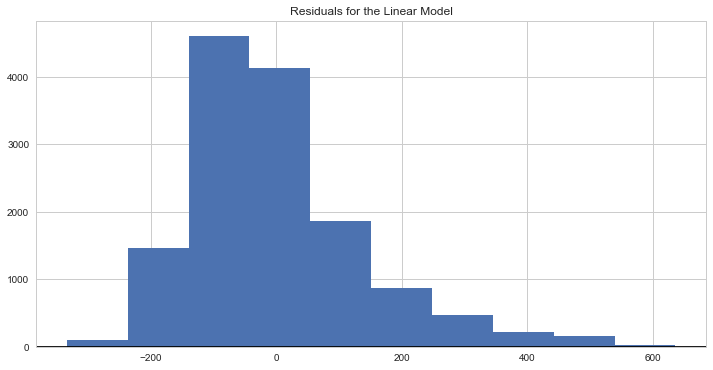

In [44]:
sns.set(style="whitegrid")
matplotlib.rcParams['figure.figsize']=(12,6)

residual = y_train - prediction
plt.hist(residual, label="Residual")
plt.axhline(0, color='k')
plt.title("Residuals for the Linear Model")

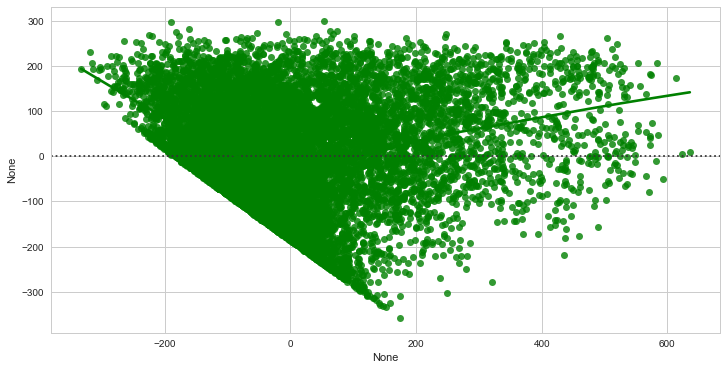

In [45]:
sns.residplot(residual, prediction, lowess=True, color="g");

The assumptions of linearity, normality, and constance variance are all violated. A polynomial regression to the degree of 2 would probably better fit this data, since there seems to be a curve.

#### **4.4** Perhaps we can do better via a model with polynomial terms. Build a dataset `X_train_poly` from `X_train` with added $x^2$ terms for `temp`, `hour`, and `humidity`. Are these polynomial terms important? How does predicted ridership change as each of `temp`, `hour`, and `humidity` increase?

In [46]:
def build_poly_model(df):
    poly_design = df[['hour','holiday','year','workingday','temp', 'atemp', 'hum', 'windspeed', 'spring', 'summer', 'fall', 'Feb', 'Mar', 'Apr', 'May', 'Jun', 'Jul', 'Aug', 'Sept', 'Oct', 'Nov', 'Dec', 'Mon', 'Tue', 'Wed', 'Thu', 'Fri', 'Sat', 'Cloudy', 'Snow', 'Storm']].copy()
    poly_design['temp2'] = df['temp']**2
    poly_design['hour2'] = df['hour']**2
    poly_design['hum2'] = df['hum']**2
    
    #reindex so variables are in a pretty order
    poly_design = poly_design[['hour','hour2','holiday','year','workingday','temp', 'temp2', 'atemp', 'hum', 'hum2', 'windspeed', 'spring', 'summer', 'fall', 'Feb', 'Mar', 'Apr', 'May', 'Jun', 'Jul', 'Aug', 'Sept', 'Oct', 'Nov', 'Dec', 'Mon', 'Tue', 'Wed', 'Thu', 'Fri', 'Sat', 'Cloudy', 'Snow', 'Storm']]
    
    poly_design = sm.add_constant(poly_design)
    
    return poly_design

X_train_poly = build_poly_model(BSS_train)
X_test_poly = build_poly_model(BSS_test)


poly_model = sm.OLS(BSS_train.counts, X_train_poly).fit()
poly_model.summary()

<class 'statsmodels.iolib.summary.Summary'>
"""
                            OLS Regression Results                            
==============================================================================
Dep. Variable:                 counts   R-squared:                       0.501
Model:                            OLS   Adj. R-squared:                  0.500
Method:                 Least Squares   F-statistic:                     421.8
Date:                Wed, 03 Oct 2018   Prob (F-statistic):               0.00
Time:                        23:10:31   Log-Likelihood:                -87102.
No. Observations:               13903   AIC:                         1.743e+05
Df Residuals:                   13869   BIC:                         1.745e+05
Df Model:                          33                                         
Covariance Type:            nonrobust                                         
==============================================================================
                 coef    std err          t      P>|t|      [0.025      0.975]
------------------------------------------------------------------------------
const       -185.2131     14.016    -13.214      0.000    -212.687    -157.739
hour          39.5786      0.662     59.777      0.000      38.281      40.876
hour2         -1.3570      0.027    -50.567      0.000      -1.410      -1.304
holiday      -13.0061      6.056     -2.148      0.032     -24.877      -1.135
year          81.0305      2.199     36.854      0.000      76.721      85.340
workingday    13.2894      2.524      5.265      0.000       8.342      18.237
temp         132.7247     58.298      2.277      0.023      18.452     246.997
temp2        109.4437     36.470      3.001      0.003      37.958     180.930
atemp         67.4957     43.532      1.550      0.121     -17.833     152.824
hum           11.8636     36.114      0.329      0.743     -58.925      82.652
hum2        -108.7057     28.944     -3.756      0.000    -165.440     -51.971
windspeed     -6.9100      9.920     -0.697      0.486     -26.354      12.534
spring        43.7116      6.805      6.424      0.000      30.374      57.049
summer        33.9087      8.066      4.204      0.000      18.098      49.720
fall          72.1937      6.878     10.497      0.000      58.712      85.675
Feb            1.6487      5.538      0.298      0.766      -9.207      12.504
Mar            9.5583      6.304      1.516      0.129      -2.798      21.914
Apr          -10.7152      9.238     -1.160      0.246     -28.824       7.393
May           -2.7388      9.789     -0.280      0.780     -21.926      16.449
Jun          -23.0368      9.922     -2.322      0.020     -42.485      -3.588
Jul          -53.5230     11.163     -4.795      0.000     -75.405     -31.642
Aug          -23.6944     10.965     -2.161      0.031     -45.188      -2.201
Sept          10.9055      9.887      1.103      0.270      -8.475      30.286
Oct            2.8452      9.262      0.307      0.759     -15.309      20.999
Nov          -16.5926      8.897     -1.865      0.062     -34.032       0.846
Dec           -6.9106      7.078     -0.976      0.329     -20.784       6.963
Mon           -2.4620      2.731     -0.901      0.367      -7.816       2.892
Tue           -3.8629      2.943     -1.313      0.189      -9.631       1.905
Wed            2.1275      2.920      0.729      0.466      -3.596       7.851
Thu           -0.2540      2.922     -0.087      0.931      -5.981       5.473
Fri            4.7347      2.923      1.620      0.105      -0.995      10.465
Sat           16.7983      4.021      4.178      0.000       8.917      24.679
Cloudy        -8.4327      2.680     -3.146      0.002     -13.687      -3.179
Snow         -47.3269      4.583    -10.327      0.000     -56.310     -38.344
Storm         35.5800     90.246      0.394      0.693    -141.315     212.475
==============================================================================
Om

**Answer**  
By adding these polynomial terms, our R-squared value increases from 0.406 to 0.501. We also see that $x^2$ terms for `temp`, `hour`, and `humidity' all have significant p values, indicating that these polynomials play a significant role in our model. 'temp'$^2$ causes an increase in ridership; whereas 'hum'$^2$ and 'hour'$^2$ cause decreases.


#### **4.5** The strange coefficients from 4.2 could also come from _multicolinearity_, where one or more predictors capture the same information as existing predictors. Why can multicolinearity lead to erroneous coefficient values? Create a temporary dataset `X_train_drop` that drops the following 'redundant' predictors from `X_train`:  `workingday` `atemp` `spring` `summer` and `fall`. Fit a multiple linear regression model to `X_train_drop`. Are the estimates more sensible in this model?

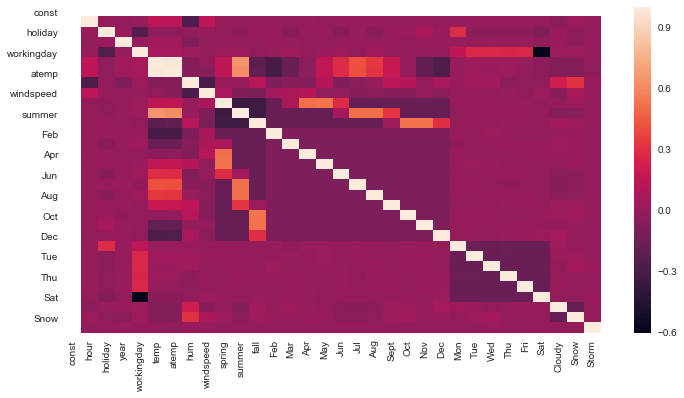

In [47]:
X_train.corr()
sns.heatmap(X_train.corr())

In [48]:
X_train_drop = X_train.drop(['workingday', 'atemp', 'spring', 'summer', 'fall'], axis=1)
display(X_train_drop.head())

model3 = sm.OLS(
    y_train,
    X_train_drop).fit()
model3.summary()

,const,hour,holiday,year,temp,hum,windspeed,Feb,Mar,Apr,...,Dec,Mon,Tue,Wed,Thu,Fri,Sat,Cloudy,Snow,Storm
0,1.0,0,0,0,0.24,0.81,0.0,0,0,0,...,0,0,0,0,0,0,1,0,0,0
1,1.0,1,0,0,0.22,0.80,0.0,0,0,0,...,0,0,0,0,0,0,1,0,0,0
2,1.0,2,0,0,0.22,0.80,0.0,0,0,0,...,0,0,0,0,0,0,1,0,0,0
3,1.0,3,0,0,0.24,0.75,0.0,0,0,0,...,0,0,0,0,0,0,1,0,0,0
4,1.0,4,0,0,0.24,0.75,0.0,0,0,0,...,0,0,0,0,0,0,1,0,0,0


<class 'statsmodels.iolib.summary.Summary'>
"""
                            OLS Regression Results                            
==============================================================================
Dep. Variable:                 counts   R-squared:                       0.402
Model:                            OLS   Adj. R-squared:                  0.401
Method:                 Least Squares   F-statistic:                     358.3
Date:                Wed, 03 Oct 2018   Prob (F-statistic):               0.00
Time:                        23:10:32   Log-Likelihood:                -88363.
No. Observations:               13903   AIC:                         1.768e+05
Df Residuals:                   13876   BIC:                         1.770e+05
Df Model:                          26                                         
Covariance Type:            nonrobust                                         
==============================================================================
                 coef    std err          t      P>|t|      [0.025      0.975]
------------------------------------------------------------------------------
const        -20.0627      8.541     -2.349      0.019     -36.805      -3.321
hour           7.2378      0.185     39.095      0.000       6.875       7.601
holiday      -35.8906      7.395     -4.854      0.000     -50.385     -21.396
year          76.3039      2.389     31.945      0.000      71.622      80.986
temp         406.2359     13.279     30.593      0.000     380.208     432.264
hum         -201.5103      7.800    -25.835      0.000    -216.799    -186.221
windspeed     11.9668     10.448      1.145      0.252      -8.512      32.446
Feb           -7.6897      5.986     -1.285      0.199     -19.422       4.043
Mar            2.8889      6.158      0.469      0.639      -9.182      14.960
Apr            1.0237      6.594      0.155      0.877     -11.902      13.950
May            7.2426      7.613      0.951      0.341      -7.680      22.165
Jun          -30.6611      8.346     -3.674      0.000     -47.020     -14.302
Jul          -67.7620      9.062     -7.477      0.000     -85.525     -49.999
Aug          -34.2712      8.628     -3.972      0.000     -51.183     -17.359
Sept          20.6406      7.882      2.619      0.009       5.191      36.090
Oct           50.7025      6.823      7.431      0.000      37.329      64.076
Nov           42.3211      6.111      6.926      0.000      30.344      54.299
Dec           34.2134      5.952      5.748      0.000      22.546      45.881
Mon            9.2907      4.570      2.033      0.042       0.333      18.248
Tue            4.7929      4.442      1.079      0.281      -3.914      13.500
Wed           13.2143      4.417      2.992      0.003       4.557      21.871
Thu            8.0051      4.445      1.801      0.072      -0.708      16.718
Fri           13.0474      4.429      2.946      0.003       4.367      21.728
Sat           14.1461      4.397      3.217      0.001       5.528      22.764
Cloudy         6.7192      2.909      2.310      0.021       1.018      12.421
Snow         -29.1668      4.828     -6.041      0.000     -38.631     -19.703
Storm         40.3125     98.759      0.408      0.683    -153.267     233.893
==============================================================================
Omnibus:                     2850.389   Durbin-Watson:                   0.749
Prob(Omnibus):                  0.000   Jarque-Bera (JB):             5702.134
Skew:                           1.231   Prob(JB):                         0.00
Kurtosis:                       4.944   Cond. No.                     1.13e+03
==============================================================================

Warnings:
[1] Standard Errors assume that the covariance matrix of the errors is correctly specified.
[2] The condition number is large, 1.13e+03. This might indicate that there are
strong multicollinearity or other numerical problems.
""

**Answer**  
Multicollinearity increase the variance of the coefficient estimates and make the estimates very sensitive to minor changes in the model. The result is that the coefficient estimates are unstable and difficult to interpret. It can cause extreme values, and changes in signs. By removing these terms, we are able to get a better model.


<div class='exercise'><b> Question 5: Subset Selection </b> </div>
Perhaps we can automate finding a good set of predictors. This question focuses on forward stepwise selection, where predictors are added to the model one by one.

**5.1** Implement forward step-wise selection to select a minimal subset of predictors that are related to the response variable. Run your code on the richest dataset, `X_train_poly`, and determine which predictors are selected.

We require that you implement the method **from scratch**. You may use the Bayesian Information Criterion (BIC) to choose the best subset size. 

<i>Note: Implementing from scratch means you are not allowed to use a solution provided by a Python library, such as sklearn or use a solution you found on the internet. You have to write all of the code on your own. However you MAY use the `model.bic` attribute implemented in statsmodels.</i>

**5.2** Does forward selection eliminate one or more of the colinear predictors we dropped in Question  4.5 (`workingday` `atemp` `spring` `summer` and `fall`)? If any of the five predictors are not dropped, explain why.

**5.3** Fit the linear regression model using the identified subset of predictors to the training set. How do the train and test $R^2$ scores for this fitted step-wise model compare with the train and test $R^2$ scores from the polynomial model fitted in Question 4.4?

### Answers

#### **5.1** Implement forward step-wise selection to select a minimal subset of predictors that are related to the response variable. Run your code on the richest dataset, `X_train_poly`, and determine which predictors are selected.

#### We require that you implement the method **from scratch**. You may use the Bayesian Information Criterion (BIC) to choose the best subset size. 

#### <i>Note: Implementing from scratch means you are not allowed to use a solution provided by a Python library, such as sklearn or use a solution you found on the internet. You have to write all of the code on your own. However you MAY use the `model.bic` attribute implemented in statsmodels.</i>

In [49]:
x = X_train_poly.iloc[:,:-1]
y = BSS_train['counts']
x.shape, y.shape

predictors = x.columns

display(x, y, predictors)

,const,hour,hour2,holiday,year,workingday,temp,temp2,atemp,hum,...,Nov,Dec,Mon,Tue,Wed,Thu,Fri,Sat,Cloudy,Snow
0,1.0,0,0,0,0,0,0.24,0.0576,0.2879,0.81,...,0,0,0,0,0,0,0,1,0,0
1,1.0,1,1,0,0,0,0.22,0.0484,0.2727,0.80,...,0,0,0,0,0,0,0,1,0,0
2,1.0,2,4,0,0,0,0.22,0.0484,0.2727,0.80,...,0,0,0,0,0,0,0,1,0,0
3,1.0,3,9,0,0,0,0.24,0.0576,0.2879,0.75,...,0,0,0,0,0,0,0,1,0,0
4,1.0,4,16,0,0,0,0.24,0.0576,0.2879,0.75,...,0,0,0,0,0,0,0,1,0,0
5,1.0,5,25,0,0,0,0.24,0.0576,0.2576,0.75,...,0,0,0,0,0,0,0,1,1,0
6,1.0,7,49,0,0,0,0.20,0.0400,0.2576,0.86,...,0,0,0,0,0,0,0,1,0,0
7,1.0,8,64,0,0,0,0.24,0.0576,0.2879,0.75,...,0,0,0,0,0,0,0,1,0,0
8,1.0,10,100,0,0,0,0.38,0.1444,0.3939,0.76,...,0,0,0,0,0,0,0,1,0,0
9,1.0,11,121,0,0,0,0.36,0.1296,0.3333,0.81,...,0,0,0,0,0,0,0,1,0,0


0         16
1         40
2         32
3         13
4          1
5          1
6          3
7          8
8         36
9         56
10        84
11        94
12       106
13       110
14        93
15        67
16        35
17        37
18        34
19        28
20        39
21        17
22        17
23         9
24         6
25         3
26         2
27         1
28         8
29        20
        ... 
13873     74
13874    136
13875    144
13876    169
13877    160
13878    138
13879    133
13880    123
13881    125
13882     47
13883     36
13884     49
13885     19
13886     11
13887      1
13888      3
13889     85
13890    196
13891    120
13892    157
13893    224
13894    203
13895    247
13896    315
13897    214
13898    164
13899    122
13900     89
13901     61
13902     49
Name: counts, Length: 13903, dtype: int64

Index(['const', 'hour', 'hour2', 'holiday', 'year', 'workingday', 'temp',
       'temp2', 'atemp', 'hum', 'hum2', 'windspeed', 'spring', 'summer',
       'fall', 'Feb', 'Mar', 'Apr', 'May', 'Jun', 'Jul', 'Aug', 'Sept', 'Oct',
       'Nov', 'Dec', 'Mon', 'Tue', 'Wed', 'Thu', 'Fri', 'Sat', 'Cloudy',
       'Snow'],
      dtype='object')

In [50]:
for k in range (1, len(predictors)):
    predictors = x.columns
    
    best_r_squared = -np.inf
    best_model_data = None

    # Enumerate subsets of the given size
    subsets_of_size_k = itertools.combinations(predictors, len(predictors))

Let's create a loop that just finds the best predictor

In [51]:
def lowest_bic(est_predictors, more_predictors):
    current_preds = []
    running_bic = []
    current_bic = []
    
    for i, predictor in enumerate(more_predictors):
        design_mat = est_predictors + [predictor]
        curr_fitted_model = OLS(endog = y_train, exog = X_train_poly[design_mat], hasconst=True).fit()
        current_bic.append(curr_fitted_model.bic)
        
    lowest_bic = min(current_bic)
    return (lowest_bic, more_predictors[current_bic.index(lowest_bic)])

Ok, now let's put this in another loop that itteratively adds the next predictor and stores the bic of that "next" best stepqise model so that we can compare them. Break the loop when the BIC starts to go up.

In [52]:
all_predictors = X_train_poly.drop(columns=['const']).columns
all_predictors = list(all_predictors)

predictors_list = []
test_predictors = all_predictors.copy()
best_bic = None
while True:
    new_bic, last_best_predictor = lowest_bic(predictors_list, test_predictors)
    
    if best_bic == None:
        best_bic = new_bic
    elif best_bic < new_bic:
        break
    elif best_bic > new_bic:
        best_bic = new_bic
    predictors_list = predictors_list + [last_best_predictor]
    test_predictors.remove(last_best_predictor)
    print(new_bic, last_best_predictor)

181370.05948206075 temp
179717.78889599905 hour
178357.82706914432 hum2
176722.95912070328 hour2
175981.5677215192 year
175316.11289253167 hum
174975.6742919337 fall
174848.4445545477 Snow
174780.8933556406 Jul
174739.97889847725 temp2
174681.61599833728 spring
174618.93471527623 Sept
174606.3563833533 Oct
174593.35851715243 holiday
174583.79233540065 summer
174579.33274081693 May
174576.98736332514 atemp
174576.9208246853 Mar


In [53]:
display(predictors_list)

['temp',
 'hour',
 'hum2',
 'hour2',
 'year',
 'hum',
 'fall',
 'Snow',
 'Jul',
 'temp2',
 'spring',
 'Sept',
 'Oct',
 'holiday',
 'summer',
 'May',
 'atemp',
 'Mar']

In [54]:
drop_predictors = []
for predictor in all_predictors:
    if predictor not in predictors_list:
        drop_predictors.append(predictor)
    else:
        pass

In [55]:
drop_predictors

['workingday',
 'windspeed',
 'Feb',
 'Apr',
 'Jun',
 'Aug',
 'Nov',
 'Dec',
 'Mon',
 'Tue',
 'Wed',
 'Thu',
 'Fri',
 'Sat',
 'Cloudy',
 'Storm']

#### **5.2** Does forward selection eliminate one or more of the colinear predictors we dropped in Question  4.5 (`workingday` `atemp` `spring` `summer` and `fall`)? If any of the five predictors are not dropped, explain why.

The predictors `atemp`, `spring`, `summer`, and `fall` were not removed. This is because removing it does not cause a significant decrease in the BIC score for the model.

#### **5.3** Fit the linear regression model using the identified subset of predictors to the training set. How do the train and test $R^2$ scores for this fitted step-wise model compare with the train and test $R^2$ scores from the polynomial model fitted in Question 4.4?

In [56]:
X_train_poly_drop = X_train_poly.drop(drop_predictors, axis=1)
display(X_train_poly_drop.head())

model4 = sm.OLS(
    y_train,
    X_train_poly_drop).fit()
model4.summary()

,const,hour,hour2,holiday,year,temp,temp2,atemp,hum,hum2,spring,summer,fall,Mar,May,Jul,Sept,Oct,Snow
0,1.0,0,0,0,0,0.24,0.0576,0.2879,0.81,0.6561,0,0,0,0,0,0,0,0,0
1,1.0,1,1,0,0,0.22,0.0484,0.2727,0.80,0.6400,0,0,0,0,0,0,0,0,0
2,1.0,2,4,0,0,0.22,0.0484,0.2727,0.80,0.6400,0,0,0,0,0,0,0,0,0
3,1.0,3,9,0,0,0.24,0.0576,0.2879,0.75,0.5625,0,0,0,0,0,0,0,0,0
4,1.0,4,16,0,0,0.24,0.0576,0.2879,0.75,0.5625,0,0,0,0,0,0,0,0,0


<class 'statsmodels.iolib.summary.Summary'>
"""
                            OLS Regression Results                            
==============================================================================
Dep. Variable:                 counts   R-squared:                       0.499
Model:                            OLS   Adj. R-squared:                  0.499
Method:                 Least Squares   F-statistic:                     769.0
Date:                Wed, 03 Oct 2018   Prob (F-statistic):               0.00
Time:                        23:10:37   Log-Likelihood:                -87125.
No. Observations:               13903   AIC:                         1.743e+05
Df Residuals:                   13884   BIC:                         1.744e+05
Df Model:                          18                                         
Covariance Type:            nonrobust                                         
==============================================================================
                 coef    std err          t      P>|t|      [0.025      0.975]
------------------------------------------------------------------------------
const       -166.4134     13.365    -12.451      0.000    -192.611    -140.216
hour          39.4373      0.649     60.800      0.000      38.166      40.709
hour2         -1.3502      0.026    -51.075      0.000      -1.402      -1.298
holiday      -26.2386      6.450     -4.068      0.000     -38.881     -13.596
year          81.1137      2.191     37.023      0.000      76.819      85.408
temp          99.3996     55.038      1.806      0.071      -8.482     207.281
temp2        112.9786     34.946      3.233      0.001      44.480     181.478
atemp         82.4241     41.700      1.977      0.048       0.686     164.162
hum           -6.7628     35.640     -0.190      0.850     -76.622      63.096
hum2         -99.3923     28.593     -3.476      0.001    -155.439     -43.346
spring        35.6581      4.190      8.509      0.000      27.444      43.872
summer        21.3772      5.511      3.879      0.000      10.574      32.180
fall          62.5140      3.894     16.053      0.000      54.881      70.147
Mar           15.9047      4.257      3.736      0.000       7.561      24.248
May           13.1080      4.739      2.766      0.006       3.819      22.397
Jul          -30.3681      4.946     -6.139      0.000     -40.064     -20.672
Sept          30.8493      4.568      6.753      0.000      21.895      39.803
Oct           18.2902      4.811      3.802      0.000       8.860      27.720
Snow         -43.4153      4.328    -10.032      0.000     -51.898     -34.933
==============================================================================
Omnibus:                     2961.647   Durbin-Watson:                   0.887
Prob(Omnibus):                  0.000   Jarque-Bera (JB):             6161.407
Skew:                           1.256   Prob(JB):                         0.00
Kurtosis:                       5.080   Cond. No.                     1.58e+04
==============================================================================

Warnings:
[1] Standard Errors assume that the covariance matrix of the errors is correctly specified.
[2] The condition number is large, 1.58e+04. This might indicate that there are
strong multicollinearity or other numerical problems.
"""

**Answer**  
The $R^2$ value decreases slightly, from 0.501 to 0.499, when compared to the model in 4.4.


#  Written Report to the Administrators [20 pts]
<br>

<div class='exercise'> <b> Question 6 </b> </div>

Write a short repost stating some of your findings on how the administrators can increase the bike share system's revenue. You might want to include suggestions such as what model to use to predict ridership, what additional services to provide, or when to give discounts, etc. 
Include your report as a pdf file in canvas. The report should not be longer than one page (300 words) and should include a maximum of 5 figures. 

#### Answers 6




See PDF
